In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import arcgis
from arcgis import GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS

In [3]:
file_path = 's3://fsq-os-places-us-east-1/release/dt=2024-11-19/places/parquet/places-00000.snappy.parquet'

In [4]:
# Read directly from S3
df = pd.read_parquet(file_path, storage_options={'anon': True})

In [16]:
# print number of rows
print(f"Number of rows: {df.shape[0]}")

Number of rows: 4180424


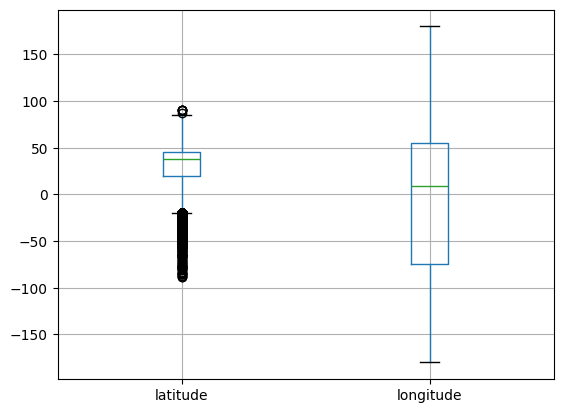

In [17]:
# make a matplotlib box plot of latitude and longitude
fig, ax = plt.subplots()
df.boxplot(column=['latitude', 'longitude'], ax=ax)
plt.show()

In [7]:
# filter to rows with a lat and long in st joseph, mi
df = df[(df['latitude'] > 42.0) & (df['latitude'] < 42.1) & (df['longitude'] > -86.5) & (df['longitude'] < -86.4)]

In [8]:
print(f"Number of rows: {df.shape[0]}")

Number of rows: 110


In [9]:
df.head()

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,date_closed,tel,website,email,facebook_id,instagram,twitter,fsq_category_ids,fsq_category_labels,dt
30657,51b61c23498e967c2f08eddf,Family Therapy,42.090938,-86.495788,M63,St.Joe,MI,49085,None,None,...,None,None,None,None,NaN,None,None,[4bf58dd8d48988d177941735],[Health and Medicine > Physician > Doctor's Of...,2024-11-19
49809,4fa27394e4b01308e7bae590,post,42.013976,-86.494090,None,Stevensville,MI,49127,None,None,...,2018-04-11,None,None,None,NaN,None,None,None,None,2024-11-19
145320,5a88cebda87921721f919555,SpineCare Decompression and Chiropractic Center,42.060139,-86.460849,3134 Niles Road,St. Joseph,MI,49085,None,None,...,None,(269) 408-8439,https://www.bestspinecare.com,info@bestspinecare.com,2.156876e+14,None,stjoechiro,[52e81612bcbc57f1066b7a3a],[Health and Medicine > Chiropractor],2024-11-19
198005,4fd8d58fe4b0859a9ea5bccd,Priebes,42.079603,-86.430327,None,Benton Harbor,MI,49022,None,None,...,None,None,None,None,NaN,None,None,[4bf58dd8d48988d130941735],[Landmarks and Outdoors > Structure],2024-11-19
201408,4daf4211f7b149e03f306785,Leep's supply,42.057438,-86.464681,215 Palladium Dr,Saint Joseph,MI,49085,None,None,...,None,None,None,None,NaN,None,None,None,None,2024-11-19


In [12]:
sedf = arcgis.features.GeoAccessor.from_xy(df, x_column='longitude', y_column='latitude', sr=4326)

In [11]:
gis = GIS()
map = gis.map('Michigan')
map

Map(center=[5484837.632514392, -9372733.492175287], extent={'xmin': -9787509.914871024, 'ymin': 4924123.621923…

In [13]:
# add the sedf to the map
sedf.spatial.plot(map)

c:\Users\ggarcia\OneDrive - Abonmarche\Documents\GitHub\Geopandas\.venv\Lib\site-packages\pandas\core\dtypes\cast.py:1056: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\ggarcia\OneDrive - Abonmarche\Documents\GitHub\Geopandas\.venv\Lib\site-packages\pandas\core\dtypes\cast.py:1080: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


True